In [97]:
import json, torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pickle import dump

with open ('./sum.json', 'r', encoding='utf-8') as file:
  copy = json.load(file)

dataset = []
y = []

for d in copy:
  for item in copy[d]:
    if (
        len(item["acc_x"]) < 20
        or len(item["acc_y"]) < 20
        or len(item["acc_z"]) < 20
    ):
      continue

    acc_x20 = item["acc_x"][-20:]
    acc_y20 = item["acc_y"][-20:]
    acc_z20 = item["acc_z"][-20:]
    gyro_x20 = item['gyro_x'][-20:]
    gyro_y20 = item['gyro_x'][-20:]
    gyro_z20 = item['gyro_x'][-20:]
    li = [acc_x20, acc_y20, acc_z20, gyro_x20, gyro_y20, gyro_z20]
    ly = [item['x'], item['y']]

    dataset.append(li)
    y.append(ly)

np_dataset = np.array(dataset, dtype=np.float32)
y_dataset = np.array(y, dtype=np.int64)

X = torch.Tensor(np_dataset)
y = torch.Tensor(y_dataset)

In [98]:
X.shape, y.shape

(torch.Size([890, 6, 20]), torch.Size([890, 2]))

torch.Size([890, 2])


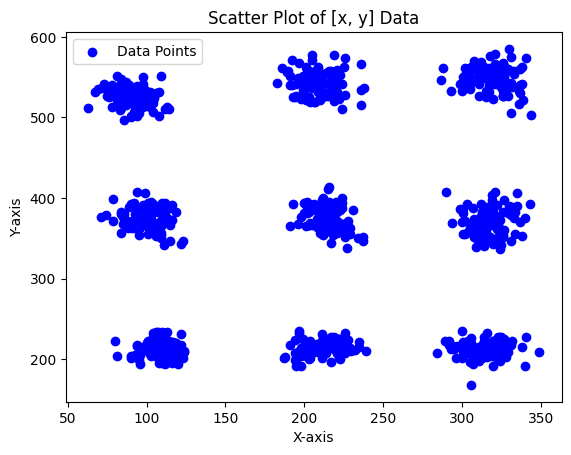

In [99]:
import matplotlib.pyplot as plt
print(y.shape)
x_values = [item[0] for item in y]
y_values = [item[1] for item in y]

# Scatter plot 그리기
plt.scatter(x_values, y_values, marker='o', color='blue', label='Data Points')

# 그래프에 라벨 등 추가
plt.title('Scatter Plot of [x, y] Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 그래프 보여주기
plt.show()

In [77]:
scaler = StandardScaler()
flatten_data = X.view(X.shape[0], -1)
scaled_data = scaler.fit_transform(flatten_data.numpy())
dump(scaler, open('./scaler.pkl', 'wb'))

In [78]:
X = torch.from_numpy(scaled_data).view(X.shape)
X.shape

torch.Size([890, 6, 20])

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2)

train_dataLoader = DataLoader(
  TensorDataset(X_train, y_train), batch_size=8, shuffle=True, drop_last=True
)

valid_dataLoader = DataLoader(
  TensorDataset(X_valid, y_valid), batch_size=8, shuffle=True, drop_last=True
)

In [80]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv1d(in_channels, out_channels=out_channels, kernel_size=3),
            nn.MaxPool1d(kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
        )

    def forward(self, x):
        y = self.layers(x)
        return y

class CNN1DRegression(nn.Module):
    def __init__(self, output_size):
        self.output_size = output_size
        super().__init__()

        self.blocks = nn.Sequential(  # x = (8, 3, 20)
            CNNBlock(6, 64),  # x = (8, 64, 9)
            CNNBlock(64, 128),  # x=(8, 128, 4)
        )

        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, output_size),
        )

    def forward(self, x):
        z = self.blocks(x)
        y = self.layers(z)
        return y

In [81]:
from copy import deepcopy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN1DRegression(output_size=2).to(device=device)
crit = nn.L1Loss()
optimizer = optim.Adam(params=model.parameters())

num_epochs = 1000
best_model = None
print_num = 30
best_val_loss = np.inf
patience = 200
cur_patience = 0

for epoch in range(1, num_epochs + 1):
  for inputs, targets in train_dataLoader:
    model.train()
    # targets = targets.type(torch.LongTensor)
    inputs = inputs.to(device)
    targets = targets.to(device).float()

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = crit(outputs, targets)
    loss.backward()
    optimizer.step()

  with torch.no_grad():
    model.eval()
    val_loss = 0

    for inputs, targets in valid_dataLoader:
      # targets = targets.type(torch.LongTensor)
      inputs = inputs.to(device)
      targets = targets.to(device).float()
      outputs = model(inputs)
      val_loss += crit(outputs, targets).item()

    val_loss /= len(valid_dataLoader)
    print(f"Cur valid Loss: {epoch}:{val_loss}")
    
  if val_loss <= best_val_loss:
    best_val_loss = val_loss
    cur_patience = 0
    best_model = deepcopy(x=model.state_dict())
  else:
    cur_patience += 1
    if cur_patience >= patience:
      print(f"Early Stop at epoch {epoch}, loss is {best_val_loss}")
      break

path = './best.pth'
torch.save(obj=best_model, f=path)

Cur valid Loss: 1:293.21493877064097
Cur valid Loss: 2:293.19773171164775
Cur valid Loss: 3:291.3765009099787
Cur valid Loss: 4:287.8707899613814
Cur valid Loss: 5:285.5005416870117
Cur valid Loss: 6:281.2306504683061
Cur valid Loss: 7:278.6285199252042
Cur valid Loss: 8:271.8781967163086
Cur valid Loss: 9:267.8126942027699
Cur valid Loss: 10:261.62253986705434
Cur valid Loss: 11:255.7058369029652
Cur valid Loss: 12:246.94160669500178
Cur valid Loss: 13:242.65266834605825
Cur valid Loss: 14:238.34993189031428
Cur valid Loss: 15:225.40160994096235
Cur valid Loss: 16:214.29498499090022
Cur valid Loss: 17:205.06435186212713
Cur valid Loss: 18:194.34158463911578
Cur valid Loss: 19:183.98060815984553
Cur valid Loss: 20:177.95156236128375
Cur valid Loss: 21:165.3854619806463
Cur valid Loss: 22:147.16912217573687
Cur valid Loss: 23:137.99358957464045
Cur valid Loss: 24:131.8520622253418
Cur valid Loss: 25:123.79778532548384
Cur valid Loss: 26:115.48240973732688
Cur valid Loss: 27:116.33216146

In [105]:
from torch.distributions import MultivariateNormal
all_y = []
with torch.no_grad():
  model.eval()
  for inputs, _ in train_dataLoader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    all_y.append(outputs)

all_y = torch.cat(all_y, dim=0).to('cpu')
input = np.array([200, 500], dtype=np.float32)

input_x = torch.Tensor(input)
cov_matrix = torch.matmul((all_y - input_x).t(), (all_y - input_x)) / (all_y.size(0) - 1)

multivariate_distribution = MultivariateNormal(input_x, cov_matrix)

In [114]:
input_x, cov_matrix

(tensor([200., 500.]),
 tensor([[ 5476.5044, -1793.4750],
         [-1793.4750, 28764.4648]]))

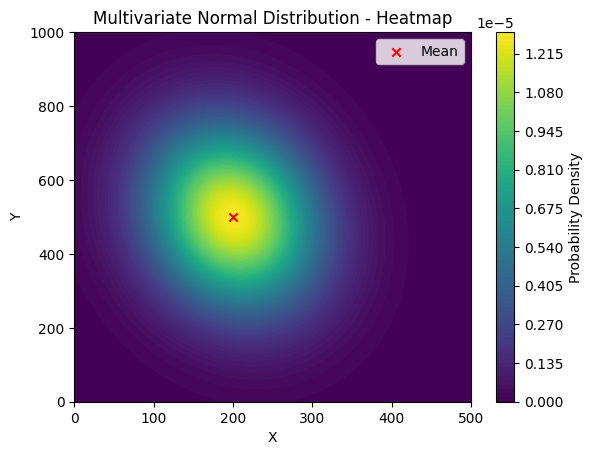

In [109]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

x = torch.linspace(0, 500, 100)
y = torch.linspace(0, 1000, 100)
X, Y = torch.meshgrid(x, y)
pos = torch.stack((X, Y), dim=-1).reshape(-1, 2)
prob_density = multivariate_distribution.log_prob(pos).exp().reshape(100, 100)

# Plot the multivariate normal distribution and filled contour lines as a heatmap
plt.contourf(X.numpy(), Y.numpy(), prob_density.numpy(), cmap='viridis', levels=100)
plt.colorbar(label='Probability Density')
plt.scatter(input_x[0], input_x[1], color='red', marker='x', label='Mean')
plt.title('Multivariate Normal Distribution - Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [112]:
test_point = torch.tensor([[1.0, 2.0]])  #테스트할 좌표 (임의로 설정)
print(input_x)
probability = multivariate_distribution.log_prob(input_x).exp()

print(f'Probability at {input_x.numpy()}: {probability.item()}')

tensor([200., 500.])
Probability at [200. 500.]: 1.2812088243663311e-05


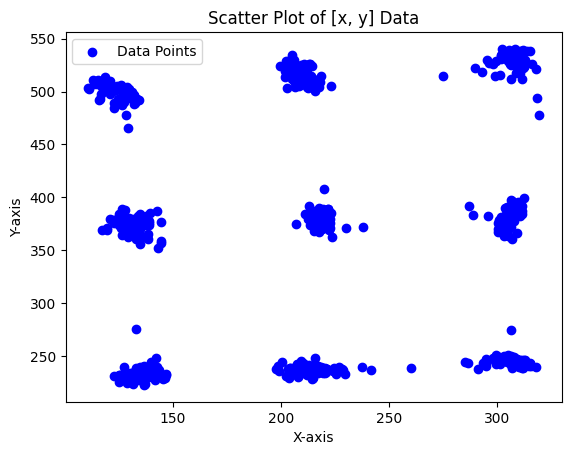

In [104]:
x_values = [item[0] for item in all_y]
y_values = [item[1] for item in all_y]

# Scatter plot 그리기
plt.scatter(x_values, y_values, marker='o', color='blue', label='Data Points')

# 그래프에 라벨 등 추가
plt.title('Scatter Plot of [x, y] Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 그래프 보여주기
plt.show()

In [19]:
'''
1. scaling
2. 좌표값이 들어옴(이 부분에 대한 오차를 보겠다)
3. 그 좌표값을 평균으로 확률 분포 모델 구성

cov mat
covariance_matrix = torch.matmul(
  (predicted_coordinates - mean).t(), 
  (predicted_coordinates - mean)) / 
  (predicted_coordinates.size(0) - 1)


# 다변량 정규분포 생성
multivariate_distribution = MultivariateNormal(mean, covariance_matrix)

# 특정 x, y 좌표에 대한 확률 계산
test_point = torch.tensor([[1.0, 2.0]])  # 테스트할 좌표 (임의로 설정)
probability = multivariate_distribution.log_prob(test_point).exp()
'''


[tensor([[216.5172, 514.6697],
         [305.4220, 365.7444],
         [304.7510, 360.2744],
         [126.1550, 366.2989],
         [296.4183, 526.5528],
         [310.9044, 235.3520],
         [131.6339, 234.2245],
         [228.4916, 374.6189]], device='cuda:0'),
 tensor([[305.1437, 365.3133],
         [125.2298, 379.2466],
         [273.6126, 373.1649],
         [312.1744, 234.2641],
         [127.5188, 365.2390],
         [205.4707, 522.5358],
         [304.0433, 366.5925],
         [131.0495, 505.0797]], device='cuda:0'),
 tensor([[306.0828, 245.9574],
         [214.9338, 525.5515],
         [310.5691, 240.6683],
         [304.4474, 360.7270],
         [213.4745, 519.1757],
         [121.3426, 368.5488],
         [307.1445, 354.6217],
         [305.5368, 363.6811]], device='cuda:0'),
 tensor([[131.6344, 232.3899],
         [217.5522, 374.5036],
         [130.8651, 234.9467],
         [214.0126, 522.2898],
         [173.5717, 245.8713],
         [210.3900, 248.2696],
         [219

# 샘플

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal

# 가속도 센서 데이터 (임의의 데이터로 대체해야 함)
acceleration_data = torch.randn(1000, 3)

# 실제 터치 좌표 데이터 (임의의 데이터로 대체해야 함)
touch_coordinates = torch.randn(1000, 2)

# 모델 정의
class TouchModel(nn.Module):
    def __init__(self):
        super(TouchModel, self).__init__()
        self.fc = nn.Linear(3, 2)  # 3은 가속도 센서 데이터의 차원, 2는 터치 좌표의 차원

    def forward(self, x):
        return self.fc(x)

# 모델 초기화
model = TouchModel()

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
epochs = 1000

for epoch in range(epochs):
    # 모델 예측
    predicted_coordinates = model(acceleration_data)

    # 손실 계산
    loss = criterion(predicted_coordinates, touch_coordinates)

    # 경사 초기화 및 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 매 100번째 epoch에서 손실 출력
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 학습된 모델로부터 확률 분포 생성
with torch.no_grad():
    model.eval()
    predicted_coordinates = model(acceleration_data)

# 생성된 확률 분포의 평균과 공분산 계산
mean = torch.mean(predicted_coordinates, dim=0)
covariance_matrix = torch.matmul((predicted_coordinates - mean).t(), (predicted_coordinates - mean)) / (predicted_coordinates.size(0) - 1)

# 다변량 정규분포 생성
multivariate_distribution = MultivariateNormal(mean, covariance_matrix)

# 특정 x, y 좌표에 대한 확률 계산
test_point = torch.tensor([[1.0, 2.0]])  # 테스트할 좌표 (임의로 설정)
probability = multivariate_distribution.log_prob(test_point).exp()

print(f'Probability at {test_point.numpy()}: {probability.item()}')


Epoch [100/1000], Loss: 1.3647
Epoch [200/1000], Loss: 1.2085
Epoch [300/1000], Loss: 1.1084
Epoch [400/1000], Loss: 1.0473
Epoch [500/1000], Loss: 1.0117
Epoch [600/1000], Loss: 0.9918
Epoch [700/1000], Loss: 0.9811
Epoch [800/1000], Loss: 0.9757
Epoch [900/1000], Loss: 0.9731
Epoch [1000/1000], Loss: 0.9719
Probability at [[1. 2.]]: 0.0


In [37]:
mean, predicted_coordinates, covariance_matrix

(tensor([-0.0428, -0.0049]),
 tensor([[ 0.0382, -0.1174],
         [-0.1207,  0.0241],
         [ 0.0381,  0.1037],
         ...,
         [-0.1414,  0.0505],
         [-0.0160, -0.0111],
         [-0.0979,  0.0180]]),
 tensor([[0.0062, 0.0010],
         [0.0010, 0.0035]]))